In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

## Load and Preprocess Data

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [3]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

#### Only keep samples with current profiles that exceed 1 kA

In [4]:
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

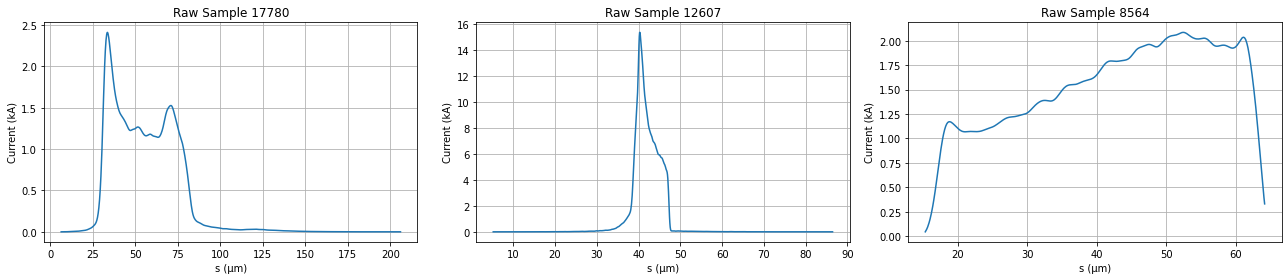

In [5]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Compute lengths

In [6]:
def compute_max_left(current):
    revcurrent = np.flip(current)
    return np.flip(np.array([revcurrent[i:].max() for i in range(len(current))]))

def compute_max_right(current):
    return np.array([current[i:].max() for i in range(len(current))])

def find_edges(s, current, threshold=0.01):
    max_left = compute_max_left(current)
    left_idx = np.where(max_left >= threshold * max_left.max())[0][0]
    left = s[left_idx]
    
    max_right = compute_max_right(current)
    right_idx = np.where(max_right >= threshold * max_right.max())[0][-1]
    right = s[right_idx]
    
    return left, right

edges = np.array([find_edges(s, current) for s, current in filtered])
widths = edges[:,1] - edges[:,0]

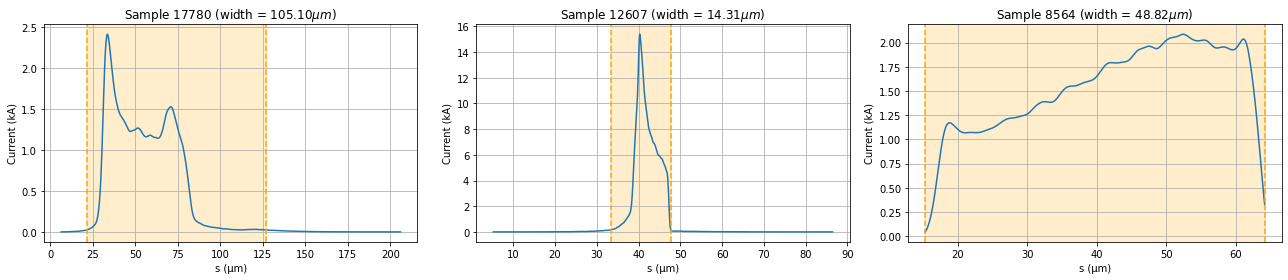

In [7]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    left, right = edges[sample]
    width = widths[sample]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample} (width = {width*1e6:.2f}$\mu m$)")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.axvspan(left*1e6, right*1e6, color="orange", alpha=0.2)
    plt.axvline(left*1e6, color="orange", ls="--")
    plt.axvline(right*1e6, color="orange", ls="--")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Interpolate into edges and center around 0

In [8]:
def resample(s, current, left, right, n=100):
    new_s = np.linspace(left, right, n)
    new_current = np.interp(new_s, s, current, left=0, right=0)
    return new_s, new_current

interpolated = [resample(s, current, left, right) for (s, current), (left, right) in zip(filtered, edges)]

In [9]:
def center_on_zero(s, current, left, right):
    old_center = left + ((right - left) / 2)
    new_s = s - old_center
    return new_s, current

recentered = [center_on_zero(s, current, left, right) for (s, current), (left, right) in zip(interpolated, edges)]

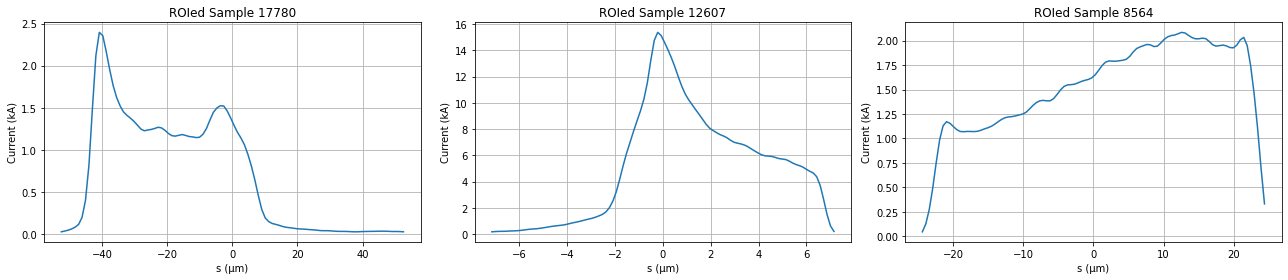

In [10]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = recentered[sample][0]
    current = recentered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"ROIed Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Make formfactors

In [11]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered])

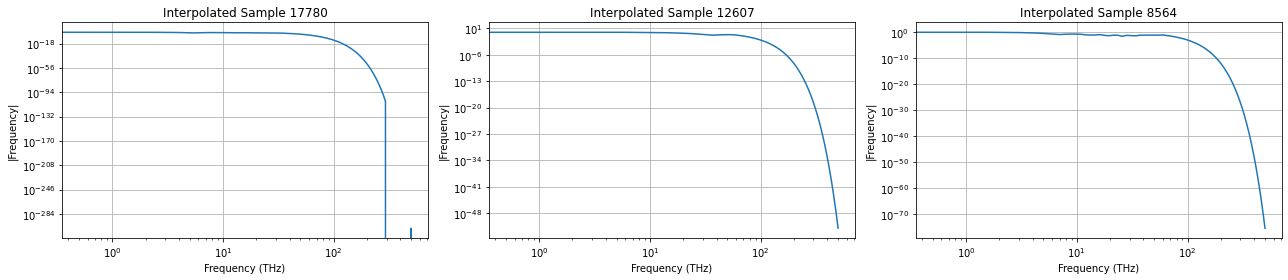

In [12]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    frequency = formfactors[sample][0]
    ff = formfactors[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.loglog(frequency*1e-12, ff, label="Formfactor")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|Frequency|")
    plt.grid()
plt.tight_layout()
plt.show()

## Training

In [25]:
def evaluate_current_predictor(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, batch_size=64)
    print(score)

def train_current_predictor(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in currents])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    neigh = KNeighborsRegressor(n_neighbors=2, weights="distance")
    neigh.fit(X_train, y_train)
    
    # evaluate_current_predictor(neigh, X_test, y_test)
    
    return neigh
                                            
cp = train_current_predictor(formfactors, recentered)

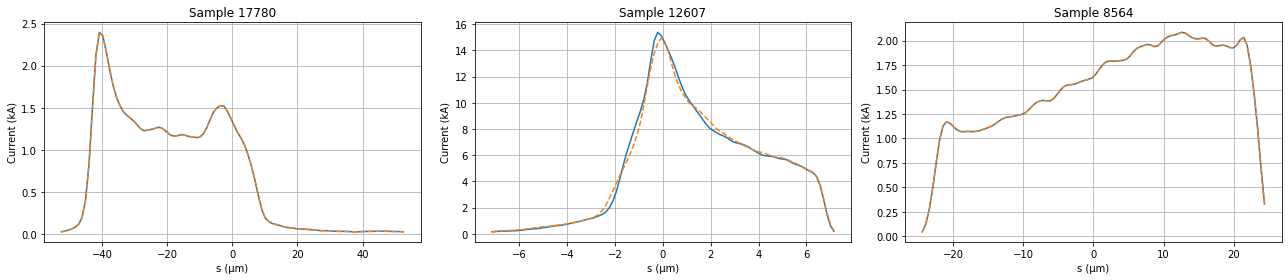

In [26]:
def do_prediction(formfactor, cp):
    X = formfactor.reshape(1, -1)
    y = cp.predict(X)
    current = y.squeeze()
    
    return current


plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s_true = recentered[sample][0]
    current_true = recentered[sample][1]
    
    formfactor = formfactors[sample][1]
    current_predict = do_prediction(formfactor, cp)
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Sample {sample}")
    plt.plot(s_true*1e6, current_true*1e-3, label="Ground Truth")
    plt.plot(s_true*1e6, current_predict*1e-3, ls="--", label="Prediction")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()